In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(17248, 24)
(17248, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RL swings
idxs = np.where(X_footsteps_accelerations_absolute[:, -1] == 1)[0]
X_footsteps_accelerations_absolute_RL_swing = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_RL_swing = Y_footsteps_accelerations_absolute[idxs]

## Predict RL foot -> x

In [8]:
X_footsteps_accelerations_absolute_RL_swing[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.09097511,  0.01569571,  0.03546102, -0.07442539,
        0.25578701,  0.13131595, -0.38037282,  0.22266933, -0.12780198,
       -0.381951  , -0.27515733,  0.12599015, -0.38960645, -0.2416217 ,
       -0.12631081, -0.38173601,  0.        ,  1.        ])

In [9]:
X_footsteps_accelerations_absolute_RL_swing[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.09097511,  0.01569571,  0.03546102, -0.07442539,
        0.25578701,  0.13131595, -0.38037282,  0.22266933, -0.12780198,
       -0.381951  , -0.27515733,  0.12599015, -0.38960645, -0.2416217 ,
       -0.12631081, -0.38173601,  0.        ,  1.        ])

### Linear Regression

In [10]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [11]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_RL_swing[:, 6:7], # actual velocity
               X_footsteps_accelerations_absolute_RL_swing[:, 3:4], # refernce velocity
               X_footsteps_accelerations_absolute_RL_swing[:, 10:12], # FL position
               X_footsteps_accelerations_absolute_RL_swing[:, 13:15], # FR position
               X_footsteps_accelerations_absolute_RL_swing[:, 16:18], # RL position
               X_footsteps_accelerations_absolute_RL_swing[:, 19:21])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_RL_swing[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_rl_relative_swinging_x = find_best_model(X, Y, runs=5000)

R2:  0.9890081741968574
RMSE:  0.019421905995051763
The lowest error is:  3.827435629578935e-06
The highest error is:  0.06685040117950924
The avg. error is:  0.01469055945057569


In [12]:
model_rl_relative_swinging_x.coef_

array([[ 0.6447439 ,  0.07364073, -0.1513184 , -0.50363216, -1.83730424,
         0.49870859,  0.94485061,  0.06602175, -1.50236821, -1.39676942]])

In [13]:
model_rl_relative_swinging_x.intercept_

array([0.27742248])

Text(0, 0.5, 'Predictions')

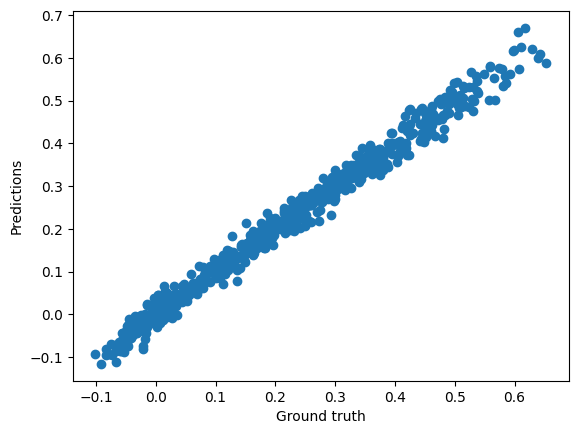

In [14]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict RL foot -> y

In [15]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_RL_swing[:, 6:7], # actual velocity
               X_footsteps_accelerations_absolute_RL_swing[:, 3:4], # refernce velocity
               X_footsteps_accelerations_absolute_RL_swing[:, 10:12], # FL position
               X_footsteps_accelerations_absolute_RL_swing[:, 13:15], # FR position
               X_footsteps_accelerations_absolute_RL_swing[:, 16:18], # RL position
               X_footsteps_accelerations_absolute_RL_swing[:, 19:21])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_RL_swing[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_rl_relative_swinging_y = find_best_model(X, Y, runs=5000)

R2:  0.9104646380550548
RMSE:  0.007446836387435329
The lowest error is:  2.4167887152802894e-05
The highest error is:  0.026784937525025254
The avg. error is:  0.005648000826353531


In [16]:
model_rl_relative_swinging_y.coef_

array([[-0.08188215,  0.01504879, -0.61338043,  0.34914438, -0.42098793,
        -1.44751393,  0.32292546, -0.30260626,  0.98173945,  0.58349991]])

In [17]:
model_rl_relative_swinging_y.intercept_

array([0.46572397])

Text(0, 0.5, 'Predictions')

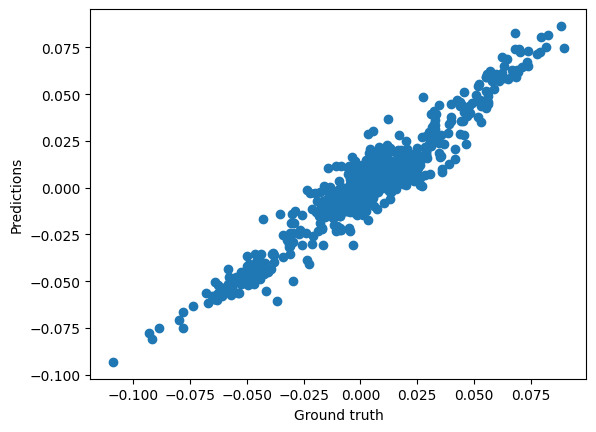

In [18]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [22]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')